In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Loading and preprocessing Image Dataset

In [2]:

import torch.utils.data.dataloader
# resizing image to 224x224 and converting to tensors
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(), 
transforms.Normalize((0.5,), (0.5,))])
# Loading dataset
train_dt = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_ld = torch.utils.data.DataLoader(train_dt, batch_size = 32, shuffle = True)

test_dt = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_ld = torch.utils.data.DataLoader(test_dt, batch_size = 32, shuffle = False)

class_names = train_dt.classes

print("Data Loaded Successfully")

Data Loaded Successfully


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([3, 224, 224]) tensor(5)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

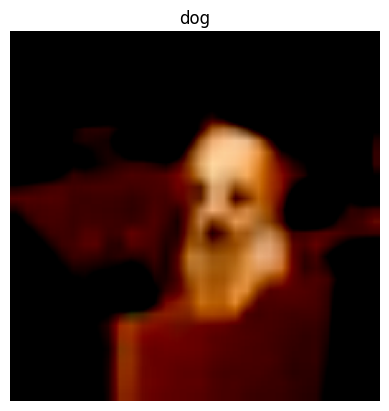

In [3]:

image_batch, label_batch = next(iter(train_ld))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

Patch Embedding Layer

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.num_patches = (img_size // patch_size) **2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride= patch_size)

    def forward (self, x):
        x= self.projection(x)
        x= x.flatten(2)
        x= x.transpose(1, 2)
        return x


Adding Class Token & Positional Encoding

In [5]:
class ViTEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size,patch_size,in_channels,embed_dim)
        self.cls_token = nn.parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x= self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x= torch.cat((cls_tokens, x), dim=1)
        x= x+self.pos_embedding
        return x
   


Multi-Head Self-Attention (MHSA)

In [6]:
class MHSA(nn.Module):
    def __init__(self, embed_dim = 768, num_heads = 12, attn_dropout = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim= embed_dim, num_heads = num_heads, dropout= attn_dropout,batch_first=True)

    def forward(self,x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)
        return attn_output

MLP Block

In [7]:
class MLP(nn.Module):
    def __init__(self, embed_dim = 768, mlp_size = 3072, dropout = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=embed_dim, out_features= mlp_size), nn.GELU(), nn.Dropout(p=dropout), 
                                 nn.Linear(in_features=mlp_size, out_features=embed_dim),nn.Dropout(p=dropout))
        

    def forward(self, x):
        x= self.layer_norm(x)
        x= self.mlp(x)
        return x


Creating a Transformer Encoder by Combining custom made layer

In [8]:
class transformerEncoder(nn.Module):
    def __init__(self, embed_dim = 768, num_heads = 12, mlp_size = 3072, attn_dropout = 0, mlp_dropout = 0.1):
        super().__init__()
        self.msa_block = MHSA(embed_dim=embed_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLP(embed_dim=embed_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x


In [10]:
transfomer_encoder_block = transformerEncoder()
from torchinfo import summary

summary(model=transfomer_encoder_block, input_size=(1, 197, 768), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings= ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
transformerEncoder (transformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MHSA (msa_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLP (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     